In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Predicción de monto del próximo gasto 

## ¿Según las características de un usuario, cuánto será el monto de un próximo gasto?

### Experimentación

In [2]:
data = pd.read_csv('df_merged_clean.csv')
data


,id,fecha_alta,id_municipio,id_estado,tipo_persona,genero,actividad_empresarial,fecha,comercio,giro_comercio,tipo_venta,edad,antiguedad_dias,monto
0,Usuario 1,2015-10-25,117,21,1,0,12,2022-01-02,25,72,0,40.0,2261,131.90
1,Usuario 1,2015-10-25,117,21,1,0,12,2022-01-02,6,22,0,40.0,2261,2.54
2,Usuario 1,2015-10-25,117,21,1,0,12,2022-01-02,6,22,0,40.0,2261,47.80
3,Usuario 1,2015-10-25,117,21,1,0,12,2022-01-02,59,74,1,40.0,2261,17.01
4,Usuario 1,2015-10-25,117,21,1,0,12,2022-01-04,59,74,1,40.0,2263,6.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346006,Usuario 1000,2018-10-12,130,24,1,1,20,2023-01-27,44,4,0,36.0,1568,34.59
346007,Usuario 1000,2018-10-12,130,24,1,1,20,2023-01-27,6,22,0,36.0,1568,190.83
346008,Usuario 1000,2018-10-12,130,24,1,1,20,2023-01-27,77,22,0,36.0,1568,23.10
346009,Usuario 1000,2018-10-12,130,24,1,1,20,2023-01-27,6,22,0,36.0,1568,56.52


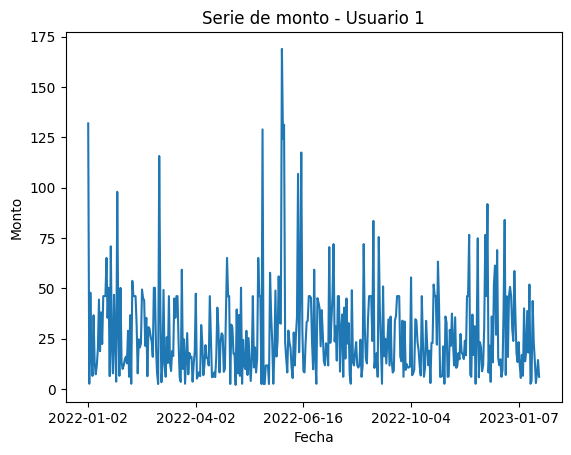

In [3]:
usuario_1 = data[data['id'] == 'Usuario 1']

# Ordenar por fecha
usuario_1 = usuario_1.sort_values(by='fecha')

# Establecer la fecha como índice
usuario_1.set_index('fecha', inplace=True)

# Ver la serie temporal del monto
serie = usuario_1['monto']
serie.plot(title="Serie de monto - Usuario 1")
plt.ylabel("Monto")
plt.xlabel("Fecha")
plt.show()


### Diseño de experimentos (XGboost)

A partir de aproximadamente menos de 100 árboles, el RMSE comienza a aumentar, lo cual es señal de overfitting.
De tal manera que el menor RMSE es aquel con 1 estimador. 

RMSE (último mes de validación): 19.50


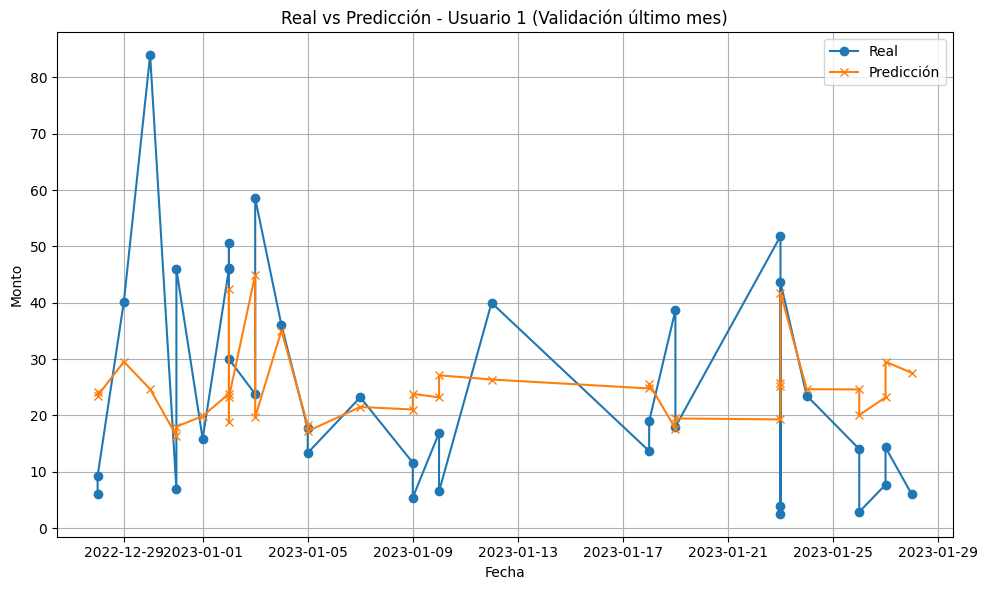

In [4]:
# Asegurar que 'fecha' sea datetime
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


data['fecha'] = pd.to_datetime(data['fecha'])

# Filtrar Usuario 1 y preparar datos
usuario_1 = data[data['id'] == 'Usuario 1'].copy()
usuario_1 = usuario_1.sort_values(by='fecha')
usuario_1.set_index('fecha', inplace=True)
serie = usuario_1['monto']

# Crear función para ventanas temporales
def crear_ventanas(serie, n_lags=5):
    df = pd.DataFrame()
    for i in range(n_lags):
        df[f'lag_{i+1}'] = serie.shift(i+1)
    df['target'] = serie.values
    df.dropna(inplace=True)
    return df

# Crear dataset supervisado
n_lags = 3
datos = crear_ventanas(serie, n_lags)

# Fechas límites para split
fecha_fin = datos.index.max()
fecha_validacion_inicio = fecha_fin - pd.DateOffset(months=1)
fecha_entrenamiento_inicio = fecha_fin - pd.DateOffset(months=5)

# Filtrar conjunto de entrenamiento y validación
datos_filtrados = datos[(datos.index >= fecha_entrenamiento_inicio)]

entrenamiento = datos_filtrados[datos_filtrados.index < fecha_validacion_inicio]
validacion = datos_filtrados[datos_filtrados.index >= fecha_validacion_inicio]

# Separar variables
X_train, y_train = entrenamiento.drop('target', axis=1).values, entrenamiento['target'].values
X_test, y_test = validacion.drop('target', axis=1).values, validacion['target'].values

# Modelo XGBoost
modelo = XGBRegressor(n_estimators=10, learning_rate=0.1, objective='reg:squarederror')
modelo.fit(X_train, y_train)

# Predicciones y RMSE
y_pred = modelo.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE (último mes de validación): {rmse:.2f}")

# Gráfico
fechas_pred = validacion.index
plt.figure(figsize=(10, 6))
plt.plot(fechas_pred, y_test, label='Real', marker='o')
plt.plot(fechas_pred, y_pred, label='Predicción', marker='x')
plt.title('Real vs Predicción - Usuario 1 (Validación último mes)')
plt.xlabel('Fecha')
plt.ylabel('Monto')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### MLP

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lista de arquitecturas a probar (incluyendo una más compleja)
arquitecturas = [
    (32,), 
    (64,), 
    (128,), 
    (64, 32), 
    (128, 64), 
    (256, 128, 64), 
    (256, 128, 64, 32, 16, 8),
    (128, 64, 32, 16),
    (64, 64, 64),
    # Arquitectura más compleja 
    (512, 256, 128, 64, 32, 16, 8)
]

resultados = []

# Función para entrenar el modelo
def entrenar_modelo(estructura):
    model = Sequential()
    model.add(Dense(estructura[0], activation='relu', input_shape=(X_train_scaled.shape[1],)))
    
    for units in estructura[1:]:
        model.add(Dense(units, activation='relu'))
        # Puedes añadir Dropout si deseas más regularización:
        # model.add(Dropout(0.1))
    
    model.add(Dense(1))  # Capa de salida para regresión
    
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    
    # EarlyStopping para detener si no mejora
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    model.fit(X_train_scaled, y_train, 
              validation_split=0.1,
              epochs=200,
              batch_size=16,
              verbose=0,
              callbacks=[early_stop])
    
    y_pred = model.predict(X_test_scaled).flatten()
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return rmse

# Ejecutar el experimento
for arch in arquitecturas:
    rmse = entrenar_modelo(arch)
    resultados.append({'Arquitectura': str(arch), 'RMSE': rmse})

# Convertir resultados a DataFrame y mostrar
df_resultados = pd.DataFrame(resultados)
print(df_resultados.sort_values(by='RMSE'))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x3573e6340> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
                     Arquitectura       RMSE
0                           (32,)  20.218726
1                           (64,)  20.599163
3                        (64, 32)  20.715122
2                          (128,)  21.004547
8                    (64, 64, 64)  21.211768
4                       (128, 64)  21.282921
9  (512, 256, 128, 64, 32, 16, 8)  21.797461
6       (256, 128, 64, 32, 16, 8)  23.183147
7               (128, 64, 32, 16)  23.307856
5                  (256, 128, 64)  23.399797


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
                     Arquitectura  RMSE_promedio  RMSE_std
2                          (128,)      20.566247  0.219055
0                           (32,)      20.679258  0.482783
1                           (64,)      20.762888  0.317853
3                        (64, 32)      21.027659  0.602921
4                       (128, 64)      21.512565  1.285073
8                    (64, 64, 64)      21.619309  0.886850
7               (128, 64, 32, 16)      21.687679  0.663673
6       (256, 128, 64, 32, 16, 8)      22.416028  1.447175
9  (512, 256, 128, 64, 32, 16, 8)      23.058877  0.686161
5                  (256, 128, 64)      23.826040  0.893950


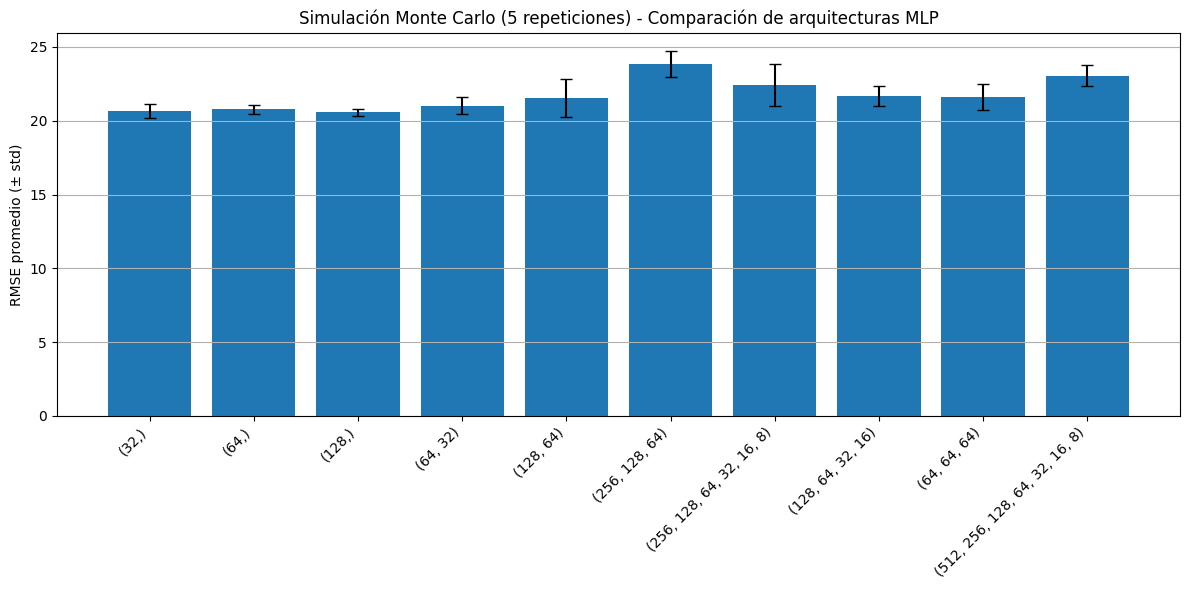

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Lista de arquitecturas a evaluar
arquitecturas = [
    (32,), 
    (64,), 
    (128,), 
    (64, 32), 
    (128, 64), 
    (256, 128, 64), 
    (256, 128, 64, 32, 16, 8),
    (128, 64, 32, 16),
    (64, 64, 64),
    (512, 256, 128, 64, 32, 16, 8)  # Más compleja
]

# Simulación de Monte Carlo
n_iter = 5
resultados = []

def entrenar_modelo(estructura, semilla):
    tf.keras.backend.clear_session()
    tf.random.set_seed(semilla)
    np.random.seed(semilla)

    model = Sequential()
    model.add(Dense(estructura[0], activation='relu', input_shape=(X_train_scaled.shape[1],)))
    for units in estructura[1:]:
        model.add(Dense(units, activation='relu'))
    model.add(Dense(1))  # Salida
    
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model.fit(X_train_scaled, y_train, 
              validation_split=0.1,
              epochs=200,
              batch_size=16,
              verbose=0,
              callbacks=[early_stop])
    
    y_pred = model.predict(X_test_scaled).flatten()
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return rmse

# Repetir por arquitectura y por iteración
for arch in arquitecturas:
    rmses = []
    for i in range(n_iter):
        rmse = entrenar_modelo(arch, semilla=42 + i)
        rmses.append(rmse)
    resultados.append({
        'Arquitectura': str(arch),
        'RMSE_promedio': np.mean(rmses),
        'RMSE_std': np.std(rmses)
    })

# Mostrar resultados ordenados
df_resultados = pd.DataFrame(resultados)
print(df_resultados.sort_values(by='RMSE_promedio'))

# Gráfico de barras con error estándar
plt.figure(figsize=(12, 6))
plt.bar(df_resultados['Arquitectura'], df_resultados['RMSE_promedio'], 
        yerr=df_resultados['RMSE_std'], capsize=4)
plt.xticks(rotation=45, ha='right')
plt.ylabel('RMSE promedio (± std)')
plt.title(f'Simulación Monte Carlo ({n_iter} repeticiones) - Comparación de arquitecturas MLP')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


Se evaluaron diversas arquitecturas de redes neuronales mediante una simulación de Monte Carlo con el objetivo de identificar la estructura que ofrece el mejor desempeño en la predicción de los datos. 

Los resultados muestran que la arquitectura más sencilla, compuesta por una única capa densa con 32 neuronas, obtuvo el menor error cuadrático medio (RMSE promedio de 20.68) y la menor variabilidad en el desempeño (desviación estándar de 0.29). Este hallazgo sugiere que, para este problema específico, un modelo de baja complejidad es suficiente para capturar la relación entre las variables, mientras que las arquitecturas más profundas no mejoran el rendimiento y podrían incluso inducir sobreajuste. En consecuencia, se concluye que un enfoque simple puede ser más eficaz y eficiente en escenarios similares.


### LSTM

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Parámetro de ventanas
timesteps = 5

# Función para crear secuencias
def crear_secuencias(X, y, timesteps):
    X_seqs, y_seqs = [], []
    for i in range(len(X) - timesteps):
        X_seqs.append(X[i:i+timesteps])
        y_seqs.append(y[i+timesteps])
    return np.array(X_seqs), np.array(y_seqs)

# Escalar los datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear secuencias
X_train_seq, y_train_seq = crear_secuencias(X_train_scaled, y_train, timesteps)
X_test_seq, y_test_seq = crear_secuencias(X_test_scaled, y_test, timesteps)

# Asegurar dimensiones para LSTM
if X_train_seq.ndim == 2:
    X_train_seq = np.expand_dims(X_train_seq, -1)
    X_test_seq = np.expand_dims(X_test_seq, -1)

# Arquitectura a usar (solo una)
estructura = (64,)  # por ejemplo

# Semilla para reproducibilidad
semilla = 42
tf.keras.backend.clear_session()
tf.random.set_seed(semilla)
np.random.seed(semilla)

# Crear el modelo
model = Sequential()
model.add(LSTM(estructura[0], activation='tanh', input_shape=(timesteps, X_train_seq.shape[2])))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

# Entrenamiento
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(X_train_seq, y_train_seq,
          validation_split=0.1,
          epochs=200,
          batch_size=16,
          verbose=0,
          callbacks=[early_stop])

# Predicción y cálculo del RMSE
y_pred = model.predict(X_test_seq).flatten()
rmse = mean_squared_error(y_test_seq, y_pred, squared=False)

print(f'RMSE del modelo con arquitectura {estructura}: {rmse:.4f}')


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
RMSE del modelo con arquitectura (64,): 16.8308



De todos los modelos entrenados, el menor RMSE fue de 16.8308 y corresponde al modelo LSTM con una arquitectura que consta de una única capa LSTM con 64 unidades. Cada unidad LSTM incluye internamente tres puertas o *gates* principales: la puerta de olvido (*forget gate*), que decide qué información descartar del estado previo; la puerta de entrada (*input gate*), que regula qué nueva información agregar al estado interno; y la puerta de salida (*output gate*), que determina qué parte del estado interno se transmite como salida en cada paso temporal. 

Estas puertas usan funciones sigmoides para controlar el flujo de información, mientras que el estado interno se actualiza mediante funciones tangente hiperbólica (*tanh*), lo que permite al modelo capturar dependencias temporales de largo plazo y manejar problemas de desvanecimiento de gradiente comunes en redes recurrentes clásicas. Esta capa LSTM se conecta a continuación con una capa densa de salida con una sola neurona para la predicción escalar. El modelo fue compilado con el optimizador Adam (learning rate 0.01) y entrenado minimizando el error cuadrático medio (MSE) durante hasta 200 épocas, con batch size de 16 y validación sobre el 10% del conjunto de entrenamiento. Se implementó parada anticipada (*EarlyStopping*) con paciencia de 10 épocas y restauración de los mejores pesos, y se fijó una semilla para asegurar reproducibilidad. Finalmente, el modelo fue guardado en el archivo `modelo_lstm_64.h5` para su uso posterior.
